In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(r"C:\Users\rishab\Downloads\Uber-Jan-Feb-FOIL.csv")

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None


In [9]:
print(df.head())

  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
print(df.isnull().sum())

dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
dtype: int64


In [12]:
daily_df = df.groupby('date').agg({'trips': 'sum'}).reset_index()

In [13]:
daily_df.set_index('date', inplace=True)
daily_df = daily_df.sort_index()

In [14]:
print(daily_df.head())

            trips
date             
2015-01-01  56437
2015-01-02  39189
2015-01-03  58449
2015-01-04  40798
2015-01-05  42752


In [15]:
import matplotlib.pyplot as plt

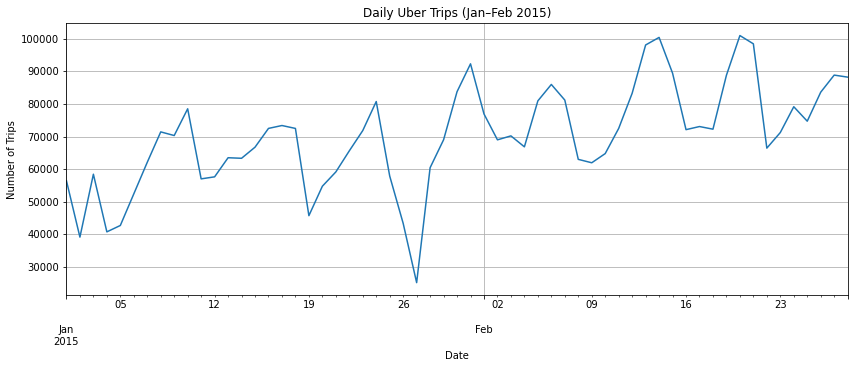

In [16]:
plt.figure(figsize=(14,5))
daily_df['trips'].plot()
plt.title("Daily Uber Trips (Jan–Feb 2015)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()

In [17]:
daily_df['day_of_week'] = daily_df.index.day_name()

In [18]:
daily_df['is_weekend'] = daily_df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [19]:
weekday_avg = daily_df.groupby('day_of_week')['trips'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

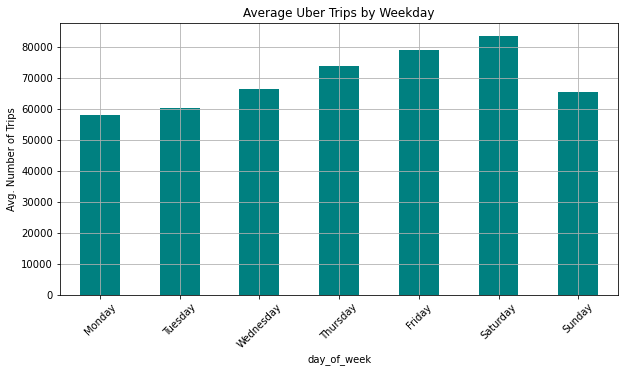

In [20]:
weekday_avg.plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Average Uber Trips by Weekday")
plt.ylabel("Avg. Number of Trips")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
daily_df['lag_1'] = daily_df['trips'].shift(1)
daily_df['lag_2'] = daily_df['trips'].shift(2)

In [22]:
daily_df['rolling_mean_3'] = daily_df['trips'].rolling(window=3).mean()
daily_df['rolling_mean_7'] = daily_df['trips'].rolling(window=7).mean()

In [23]:
daily_df = daily_df.dropna()

In [24]:
print(daily_df.head())

            trips day_of_week  is_weekend    lag_1    lag_2  rolling_mean_3  \
date                                                                          
2015-01-07  62102   Wednesday           0  52426.0  42752.0    52426.666667   
2015-01-08  71413    Thursday           0  62102.0  52426.0    61980.333333   
2015-01-09  70296      Friday           0  71413.0  62102.0    67937.000000   
2015-01-10  78484    Saturday           1  70296.0  71413.0    73397.666667   
2015-01-11  57026      Sunday           1  78484.0  70296.0    68602.000000   

            rolling_mean_7  
date                        
2015-01-07    50307.571429  
2015-01-08    52447.000000  
2015-01-09    56890.857143  
2015-01-10    59753.000000  
2015-01-11    62071.285714  


# Model Building (Time-Series Aware)

In [30]:
daily_df.columns

Index(['trips', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2',
       'rolling_mean_3', 'rolling_mean_7'],
      dtype='object')

In [31]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [32]:
encoder = OneHotEncoder(sparse=False, drop='first')
dow_encoded = encoder.fit_transform(daily_df[['day_of_week']])

In [33]:
dow_encoded_df = pd.DataFrame(dow_encoded, index=daily_df.index, columns=encoder.get_feature_names(['day_of_week']))

In [34]:
X = pd.concat([
    daily_df[['lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'is_weekend']],
    dow_encoded_df
], axis=1)

In [35]:
y = daily_df['trips']

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [37]:
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42)

In [38]:
mape_scores = []

In [39]:
for train_idx, test_idx in tscv.split(X):
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [40]:
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [41]:
 mape = mean_absolute_percentage_error(y_test, preds)
mape_scores.append(mape)

In [45]:
print(f"Random Forest Average MAPE: {np.mean(mape_scores):.2%}")

Random Forest Average MAPE: 7.14%


In [51]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

In [52]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
mape_scores_xgb = []

In [54]:
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [56]:
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)

In [57]:
mape = mean_absolute_percentage_error(y_test, preds)
mape_scores_xgb.append(mape)

In [58]:
print(f"XGBoost Average MAPE: {np.mean(mape_scores_xgb):.2%}")

XGBoost Average MAPE: 8.27%


In [59]:
for train_idx, test_idx in tscv.split(X):
    pass  

In [60]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [61]:
preds = rf.predict(X_test)

In [80]:
import matplotlib.pyplot as plt

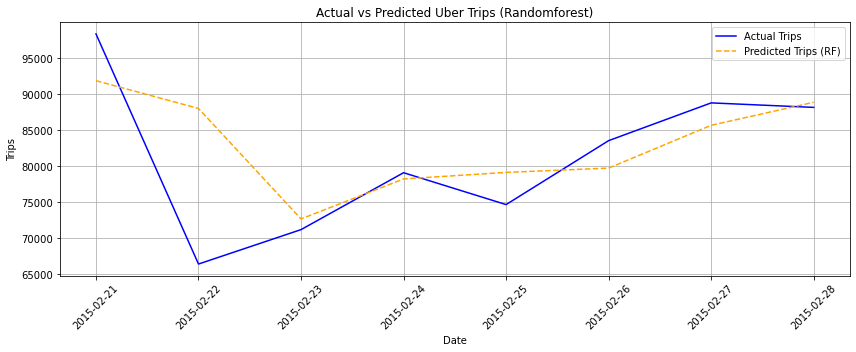

In [67]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual Trips', color='blue')
plt.plot(y_test.index, preds, label='Predicted Trips (RF)', color='orange', linestyle='--')
plt.title("Actual vs Predicted Uber Trips (Randomforest)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
xgbr.fit(X_train, y_train)
xgb_preds = xgbr.predict(X_test)

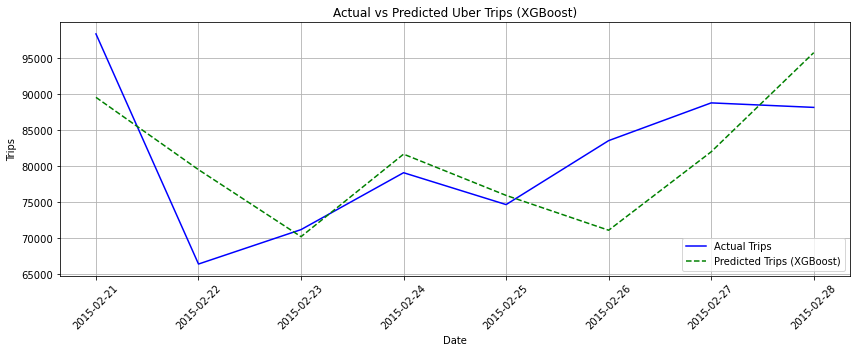

In [66]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual Trips', color='blue')
plt.plot(y_test.index, xgb_preds, label='Predicted Trips (XGBoost)', color='green', linestyle='--')
plt.title("Actual vs Predicted Uber Trips (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
rf_preds = rf.predict(X_test)
xgb_preds = xgbr.predict(X_test)

In [69]:
rf_weight = 1 / 7.14
xgb_weight = 1 / 8.27  
total = rf_weight + xgb_weight

In [70]:
rf_weight /= total
xgb_weight /= total

In [71]:
ensemble_preds = (rf_weight * rf_preds) + (xgb_weight * xgb_preds)

In [72]:
from sklearn.metrics import mean_absolute_percentage_error
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)

In [73]:
print(f"Ensemble MAPE: {ensemble_mape:.2%}")

Ensemble MAPE: 7.36%


In [76]:
import matplotlib.pyplot as plt

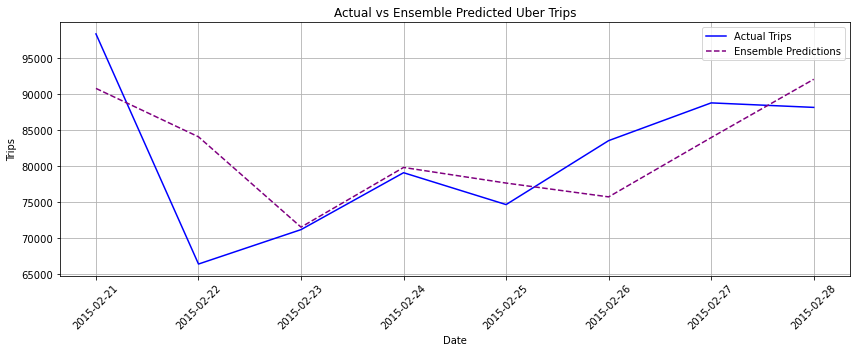

In [75]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual Trips', color='blue')
plt.plot(y_test.index, ensemble_preds, label='Ensemble Predictions', color='purple', linestyle='--')
plt.title("Actual vs Ensemble Predicted Uber Trips")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
importances = rf.feature_importances_
feature_names = X.columns

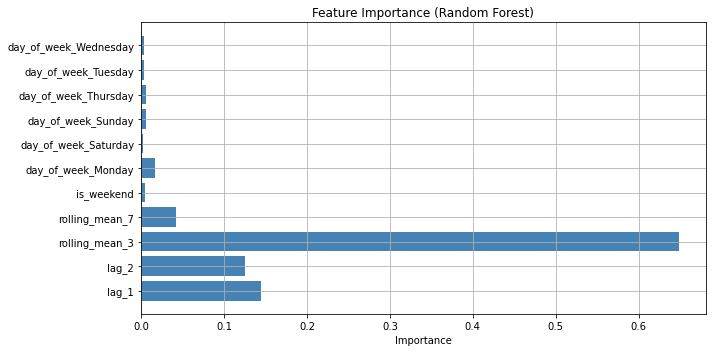

In [78]:
plt.figure(figsize=(10,5))
plt.barh(feature_names, importances, color='steelblue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
xgbr.feature_names_in_ 

array(['lag_1', 'lag_2', 'rolling_mean_3', 'rolling_mean_7', 'is_weekend',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday'], dtype='<U21')

In [81]:
import numpy as np

In [82]:
xgb_importances = xgbr.feature_importances_
xgb_features = xgbr.feature_names_in_

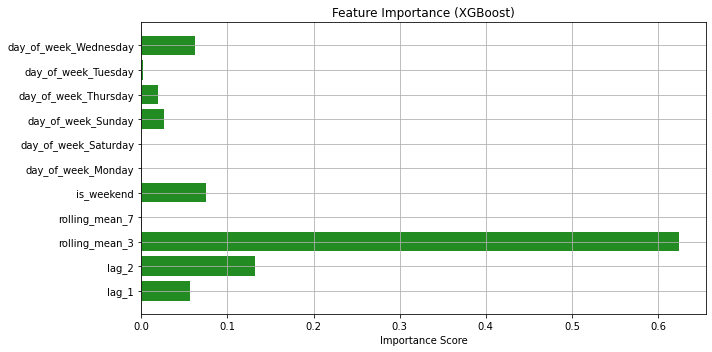

In [83]:
plt.figure(figsize=(10,5))
plt.barh(xgb_features, xgb_importances, color='forestgreen')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
residuals_rf = y_test - rf_preds

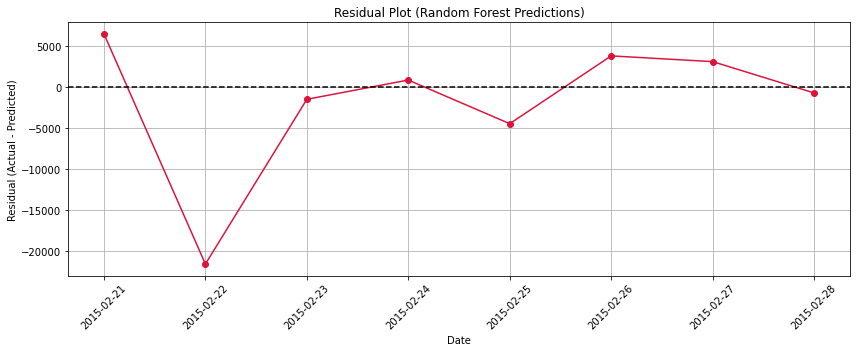

In [85]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, residuals_rf, marker='o', linestyle='-', color='crimson')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Plot (Random Forest Predictions)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

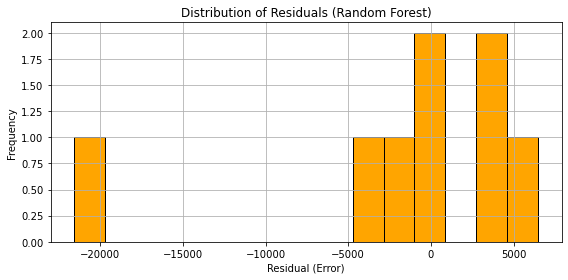

In [86]:
plt.figure(figsize=(8,4))
plt.hist(residuals_rf, bins=15, color='orange', edgecolor='black')
plt.title("Distribution of Residuals (Random Forest)")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
residuals_xgb = y_test - xgb_preds

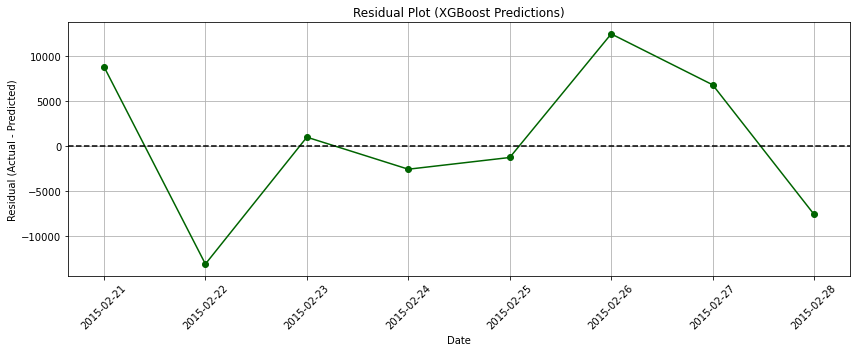

In [88]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, residuals_xgb, marker='o', linestyle='-', color='darkgreen')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Plot (XGBoost Predictions)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

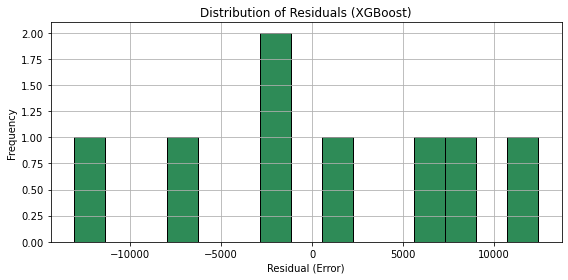

In [89]:
plt.figure(figsize=(8,4))
plt.hist(residuals_xgb, bins=15, color='seagreen', edgecolor='black')
plt.title("Distribution of Residuals (XGBoost)")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
forecast_df = pd.DataFrame({
    'date': y_test.index,
    'actual_trips': y_test.values,
    'rf_predicted': rf_preds,
    'xgb_predicted': xgb_preds,
    'ensemble_predicted': ensemble_preds,
    'rf_residual': residuals_rf,
    'xgb_residual': residuals_xgb
})

forecast_df.to_csv("forecast_results.csv", index=False)
print("Exported: forecast_results.csv")

Exported: forecast_results.csv


In [91]:
eda_df = daily_df.copy().reset_index()  # converts index to 'date' column
eda_df.to_csv("daily_summary.csv", index=False)
print("Exported: daily_summary.csv")

Exported: daily_summary.csv
